In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from yellowbrick.text import FreqDistVisualizer
from datetime import datetime, timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import glob
from PIL import Image
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lisaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df_fake = pd.read_csv("data/raw/Fake.csv")
df_fake, df_fake_test = train_test_split(df_fake, test_size=0.2, random_state=123)
df_true = pd.read_csv("data/raw/True.csv")
df_true, df_true_test = train_test_split(df_true, test_size=0.2, random_state=123)
clean_df = pd.read_csv("data/processed/all_news.csv")
clean_df, clean_df_test = train_test_split(clean_df, test_size=0.2, random_state=123)

In [5]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18784 entries, 11545 to 19966
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    18784 non-null  object
 1   text     18784 non-null  object
 2   subject  18784 non-null  object
 3   date     18784 non-null  object
dtypes: object(4)
memory usage: 733.8+ KB


In [6]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17133 entries, 6226 to 19966
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    17133 non-null  object
 1   text     17133 non-null  object
 2   subject  17133 non-null  object
 3   date     17133 non-null  object
dtypes: object(4)
memory usage: 669.3+ KB


In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35413 entries, 24080 to 15725
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35413 non-null  object
 1   text     35413 non-null  object
 2   subject  35413 non-null  object
 3   date     35403 non-null  object
 4   label    35413 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


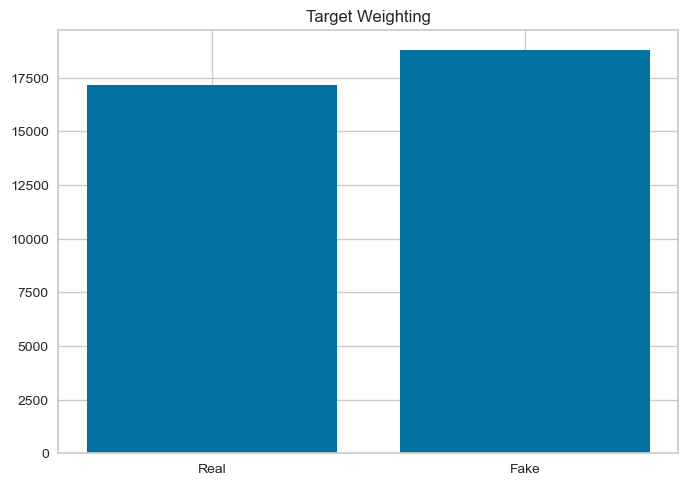

<Figure size 800x550 with 0 Axes>

In [8]:
class_df = pd.DataFrame({"Real": [len(df_true)], "Fake": [len(df_fake)]}, index = ["Count"])
class_df

plt.title('Target Weighting')
plt.bar(class_df.columns,class_df.loc["Count"])
plt.show()
plt.savefig("img/Target_weight.jpg")

In [9]:
#Count of topics in each Data Frame from Raw files
subject_df = pd.DataFrame()

all_df = [df_fake, df_true]

for df in all_df:
    counts_df = pd.DataFrame(df["subject"].value_counts().reset_index())
    subject_df = pd.concat([subject_df, counts_df], axis =1)

subject_df.columns = ["Fake Subjects", "Count of Each Subject", "Real Subjects", "Count of Each Subject"]
subject_df

,Fake Subjects,Count of Each Subject,Real Subjects,Count of Each Subject
0,News,7268,politicsNews,9018.0
1,politics,5452,worldnews,8115.0
2,left-news,3578,NaN,NaN
3,Government News,1248,NaN,NaN
4,US_News,619,NaN,NaN
5,Middle-east,619,NaN,NaN


In [10]:
#Count of topics in processed data files
subject_counts_clean_df = pd.DataFrame(clean_df.groupby(by=["label"])["subject"].value_counts())
subject_counts_clean_df = subject_counts_clean_df.rename(columns = {'subject':'Count'})
subject_counts_clean_df.index.names = ['Target','Subject']
subject_counts_clean_df

Count
Target Subject            
fake   other         10625
       politicsNews   6935
       worldnews       604
real   politicsNews   9120
       worldnews      8129

In [11]:
#Finding text length (word counts) in raw file and clean data file
data_dic = {'Average word count': [],
        'Shortest word count': [],
        'Longest word count': []}

all_df = [clean_df, df_fake, df_true]
column = "title"

for df in all_df:
    data_dic['Average word count'].append(df[column].str.len().mean().round())
    data_dic['Shortest word count'].append(df[column].str.len().min())
    data_dic['Longest word count'].append(df[column].str.len().max().max())

word_count_df = pd.DataFrame(data_dic, index = ['All clean text', 'Fake Text', 'True Text'])
word_count_df

,Average word count,Shortest word count,Longest word count
All clean text,80.0,8,286
Fake Text,94.0,8,286
True Text,65.0,26,133


In [12]:
clean_df

,title,text,subject,date,label
24080,Trump Claims ‘Any Negative Polls’ Are ‘FAKE N...,Donald Trump kicked off his Monday morning by ...,other,2017-02-06,fake
18919,Iraqi PM calls on Kurds to cancel independence...,Iraq s Prime Minister Haider al-Abadi demande...,worldnews,2017-09-27,real
20596,French minister calls out Trump on climate cha...,French Environment Minister Nicolas Hulot sai...,worldnews,2017-09-08,real
4011,Exclusive: Trump vows to fix or scrap South Ko...,U.S. President Donald Trump told Reuters on T...,politicsNews,2017-04-28,real
26930,Dallas Police Chief Tells Congress To Shove T...,"It started out as an observation, then it turn...",other,2016-07-11,fake
...,...,...,...,...,...
7763,North Carolina offers reward in arson at local...,"North Carolina will pay up to $5,000 for tips...",politicsNews,2016-10-19,real
15377,"Zimbabwe's axed VP is safe, traveling to South...",Zimbabwe s former vice president Emmerson Mna...,worldnews,2017-11-08,real
17730,France calls for Catalonia discussions within ...,France on Wednesday reiterated a call for the...,worldnews,2017-10-11,real
28030,WATCH: President Obama’s ‘Couch Commander’ Co...,For his final White House Correspondent s Dinn...,other,2016-04-30,fake


In [13]:
#Generate two dataframes of fake and real news from processed clean_data
fake_df = clean_df.query("label == 'fake'")
real_df = clean_df.query("label == 'real'")

In [14]:
def create_wordCloud(df):
    ''' 
    A function to display plots given an English text data frame. 
    '''

    #To create a list of words
    words = " ".join(df["text"].tolist())

    #Generate word cloud
    wordcloud = WordCloud(max_font_size=40, 
                          width=500, 
                          height=400, 
                          stopwords = STOPWORDS,
                          max_words=100,
                          min_word_length = 2,
                          collocations=False).generate(words)

    return wordcloud

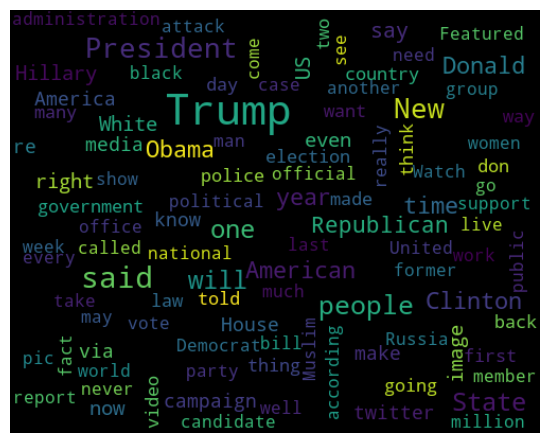

In [15]:
#Word cloud for fake news text and saving to file
fake_wc = create_wordCloud(fake_df)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/wordcloud_fake.png')

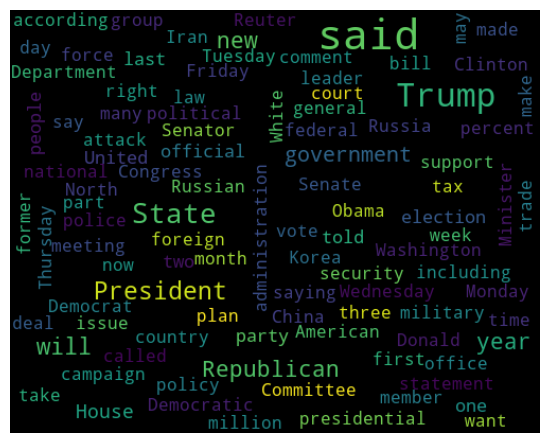

In [16]:
# Word cloud for real news text
real_wc = create_wordCloud(real_df)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('img/wordcloud_real.png')

<AxesSubplot: title={'center': 'Frequency Distribution of Top 20 tokens'}>

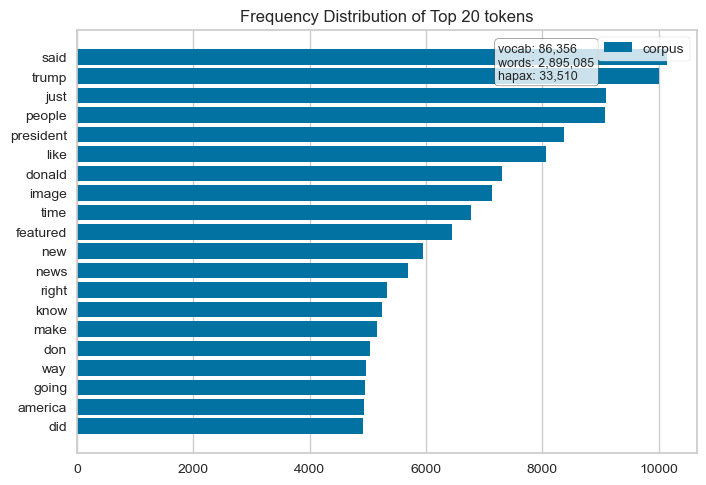

In [19]:
#Generate Count Vectorizer for Fake news text
countvec_fake = CountVectorizer(binary=True, stop_words='english')
fake_train_vec = countvec_fake.fit_transform(fake_df['text'])
fake_features = countvec_fake.get_feature_names_out()

#Display highest frequency words in Fake text
visualizer = FreqDistVisualizer(features=fake_features, n=20)
visualizer.fit(fake_train_vec)

#Display plot and save image to folder
visualizer.show(outpath='img/freqdist_fake.png')

<AxesSubplot: title={'center': 'Frequency Distribution of Top 20 tokens'}>

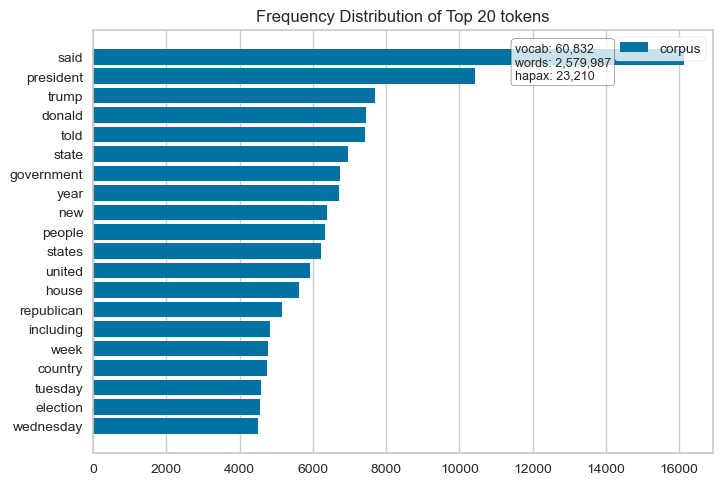

In [21]:
#Generate Count Vectorizer for Real news text
countvec_real = CountVectorizer(binary=True, stop_words='english')
real_train_vec = countvec_real.fit_transform(real_df['text'])
real_features = countvec_real.get_feature_names_out()

#Display highest frequency words in real news text
visualizer = FreqDistVisualizer(features=real_features, n=20)
visualizer.fit(real_train_vec)

#Display plot and save image to folder
visualizer.show(outpath='img/freqdist_real.png')

In [23]:
#Convert date field to date index in real_df
real_date = pd.to_datetime(real_df["date"])
real_df.index = pd.Index(real_date)

#Count monthly frequency of articles in fake_df
real_df_freq = real_df.resample("M").count()
#fake_df_freq["date"] = fake_df_freq.index

In [24]:
#Convert date field to date index in fake_df
fake_date = pd.to_datetime(fake_df["date"])
fake_df.index = pd.Index(fake_date)

#Count monthly frequency of articles in fake_df
fake_df_freq = fake_df.resample("M").count()
#fake_df_freq["date"] = fake_df_freq.index

fake_df_freq


,title,text,subject,date,label
date,,,,,
2015-03-31,6,6,6,6,6
2015-04-30,249,249,249,249,249
2015-05-31,244,244,244,244,244
2015-06-30,188,188,188,188,188
2015-07-31,233,233,233,233,233
2015-08-31,170,170,170,170,170
2015-09-30,162,162,162,162,162
2015-10-31,218,218,218,218,218
2015-11-30,209,209,209,209,209


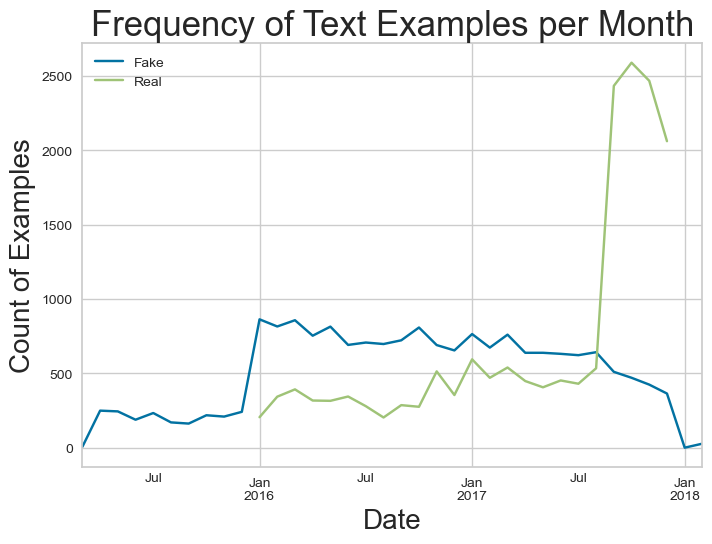

In [25]:
#Plot Date and Frequency count of examples per month
fake_df_freq["text"].plot()
real_df_freq["text"].plot()
plt.xlabel("Date",  size = 20)
plt.ylabel("Count of Examples", size = 20)
plt.title("Frequency of Text Examples per Month", size = 25)
plt.legend(["Fake", "Real"])
plt.savefig('img/freq_per_month.png')

In [60]:
txt = fake_df["text"][1]
txt

'It started out as an observation, then it turned into a joke, and but it s become downright insulting. Each time America suffers from another horrific mass shooting, Republicans in Congress send their  thoughts and prayers  and do absolutely nothing else. Rather than work towards solutions, conservative politicians have found that merely saying a prayer before bed somehow absolves them of their reprehensible inaction towards gun violence.And Dallas Police Chief David Brown, like so many of us, is absolutely fed up.At a press conference updating the country about the investigation into the ambush of police officers in Dallas following a peaceful anti-police brutality march, he didn t remain silent about the culpability of Congress. In short, Chief Brown has had a lot of long days trying to fulfill his obligation to the public and get answers, but he s noticed lawmakers can t say the same. It s been business as usual   and that means no business on finding solutions to mass shootings.Da

In [61]:
def create_distribution(text):
    ''' 
    A function to display frequency of top 20 words in text (string)
    '''

    # Clean text up to remove punctuation 
    skips = [".", ",", ";", ":", "'", '"', "\n", "!", "?", "(", ")", "@"]
    stop_words = set(stopwords.words('english'))
        
    for ch in skips:
        text = text.replace(ch, "")

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Create frequency distribution
    fdist = nltk.FreqDist(filtered_tokens)

    # Get top 20 most frequent words
    top_words = fdist.most_common(20)
    top_words.sort(key=lambda x: x[1], reverse=True) # Sort in descending order

    # Create bar plot of top 20 most frequent words
    plt.figure(figsize=(10, 6))
    plt.barh([word[0] for word in top_words], [word[1] for word in top_words])
    plt.title("Top 20 most frequent words (without stopwords)")
    plt.xlabel("Count")
    plt.ylabel("Words")
    return plt.show()

It started out as an observation, then it turned into a joke, and but it s become downright insulting. Each time America suffers from another horrific mass shooting, Republicans in Congress send their  thoughts and prayers  and do absolutely nothing else. Rather than work towards solutions, conservative politicians have found that merely saying a prayer before bed somehow absolves them of their reprehensible inaction towards gun violence.And Dallas Police Chief David Brown, like so many of us, is absolutely fed up.At a press conference updating the country about the investigation into the ambush of police officers in Dallas following a peaceful anti-police brutality march, he didn t remain silent about the culpability of Congress. In short, Chief Brown has had a lot of long days trying to fulfill his obligation to the public and get answers, but he s noticed lawmakers can t say the same. It s been business as usual   and that means no business on finding solutions to mass shootings.Dal

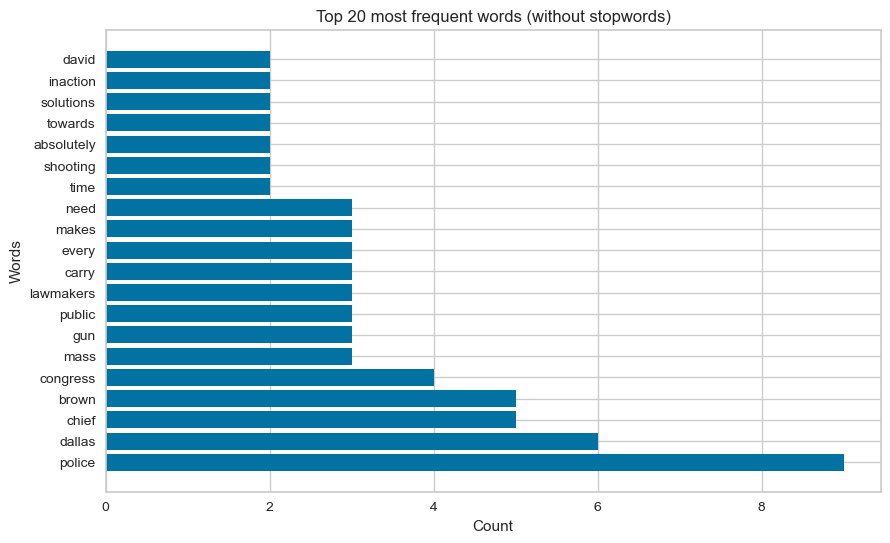

In [62]:
#Text function
txt = fake_df["text"][1]
print(txt)
create_distribution(txt)